In [1]:
from datascience import *
import numpy as np
%matplotlib inline

In [2]:
scores = Table.read_table("scores.csv")
scores.show(5)

Midterm 1,Midterm 2,Mentored
28,20,False
28.5,35,False
23.5,13.5,False
24.5,22.5,True
28.5,35.5,True


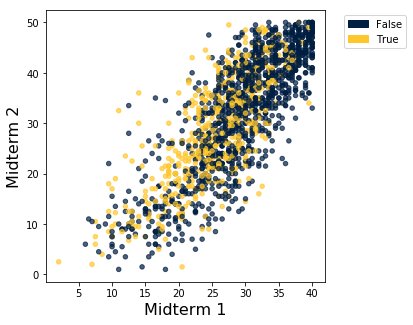

In [3]:
scores.scatter('Midterm 1', 'Midterm 2', colors='Mentored')

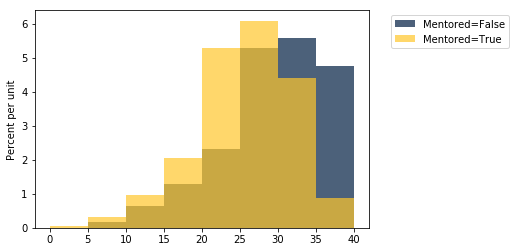

In [4]:
scores.hist('Midterm 1', group='Mentored', bins=np.arange(0, 41, 5), normed=True)

In [5]:
def standard_units(any_numbers):
    return (any_numbers - np.mean(any_numbers))/np.std(any_numbers)  

def correlation(t, x, y):
    return np.mean(standard_units(t.column(x))*standard_units(t.column(y)))

def slope(t, x, y):
    r = correlation(t, x, y)
    return r * np.std(t.column(y))/np.std(t.column(x))

def intercept(t, x, y):
    a = slope(t, x, y)
    return np.mean(t.column(y)) - a * np.mean(t.column(x))

def fitted_values(t, x, y):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * t.column(x) + b

def residuals(t, x, y):
    return t.column(y) - fitted_values(t, x, y)

def prediction_at(t, x, y, value_of_x):
    a = slope(t, x, y)
    b = intercept(t, x, y)
    return a * value_of_x + b

In [6]:
s = scores.where('Mentored', False)
scores_with_pred = s.with_column('Predicted MT2', fitted_values(s, 0, 1))
scores_with_resid = s.with_column('Improvement', residuals(s, 0, 1))
scores_with_resid

Midterm 1,Midterm 2,Mentored,Improvement
28,20,False,-10.4423
28.5,35,False,3.87433
23.5,13.5,False,-10.7916
24,22.5,False,-2.47505
19.5,20,False,1.17557
29,29.5,False,-2.30907
33.5,40.5,False,2.54031
35,46,False,5.99011
27,31.5,False,2.42454
31,43.5,False,8.95732


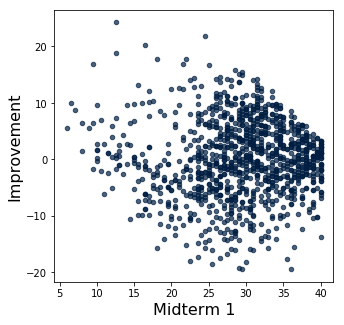

In [7]:
scores_with_resid.scatter('Midterm 1', 'Improvement')

In [39]:
examples = scores.where("Mentored", False)

def predict_mt2(mt1):
    near = examples.where("Midterm 1", are.between_or_equal_to(mt1-2, mt1+2))
    return near.column("Midterm 2").mean()

mt1_scores = examples.select("Midterm 1").sort(0, distinct=True)
predictions = mt1_scores.with_column("Predicted MT 2", 
                                     mt1_scores.apply(predict_mt2, "Midterm 1"))


predictions

Midterm 1,Predicted MT 2
6,8.3
6.5,8.3
7,8.58333
8,9.26667
9,8.88235
9.5,8.63158
10,8.84783
10.5,10.9074
11,10.8438
11.5,10.9091


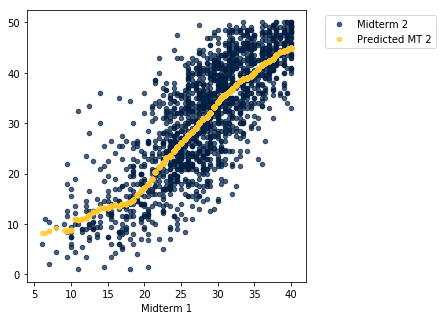

In [40]:
t = scores.join("Midterm 1", predictions)
t.drop("Mentored").scatter(0)

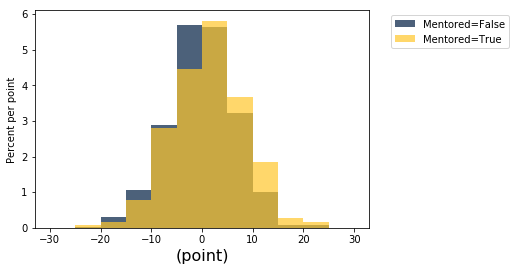

In [32]:
scores_with_improvements = t.with_column("Improvement", t.column("Midterm 2") - t.column("Predicted MT 2"))
scores_with_improvements.hist("Improvement", bins=np.arange(-30, 31, 5), group="Mentored", unit="point")

In [33]:
def of_at_least_5(values):
    return sum(values >= 5) / len(values)

scores_with_improvements.select(2, 4).group("Mentored", of_at_least_5).set_format(1, PercentFormatter)

Mentored,Improvement of_at_least_5
False,21.90%
True,29.63%


In [34]:
scores_with_improvements.group("Mentored", np.mean)

Mentored,Midterm 1 mean,Midterm 2 mean,Predicted MT 2 mean,Improvement mean
False,29.3461,32.2821,32.3047,-0.0226162
True,25.5945,28.5629,27.082,1.48083


In [12]:
def diff_in_means(observations):
    diff_in_means = []
    for i in np.arange(2000):
        shuffled = observations.sample(with_replacement = False).column('Improvement')
        t = Table().with_column('Shuffled', shuffled, 'Mentored', observations.column('Mentored'))
        grouped = t.group('Mentored', np.average)
        diff_in_means.append(grouped.column(1).item(1) - grouped.column(1).item(0))
    return diff_in_means

a = diff_in_means(scores_with_improvements)

Observed Test Statistic 1.172436397757


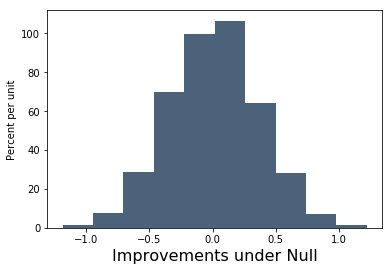

In [24]:
obs_grouped = scores_with_improvements.group("Mentored", np.mean).drop(1,2,3)
obs_test_stat = obs_grouped.column(1).item(1) - obs_grouped.column(1).item(0)
print("Observed Test Statistic", obs_test_stat)
Table().with_column('Improvements under Null', a).hist()

In [35]:
def mean_ci(observations):
    means = []
    for i in np.arange(2000):
        means.append(observations.sample().column("Improvement").mean())
    lower, upper = percentile(2.5, means), percentile(97.5, means)
    print("Mean improvement:", observations.column("Improvement").mean())
    print("95% CI of mean improvement:", lower, "to", upper)

mentored = scores_with_improvements.where("Mentored", True)
mean_ci(mentored)

Mean improvement: 1.48082915986
95% CI of mean improvement: 0.866769811944 to 2.07106023607


In [36]:
mean_ci(mentored.where('Midterm 1', are.below(20)))

Mean improvement: 2.7563833751
95% CI of mean improvement: 1.43248280296 to 4.04725517326


In [37]:
mean_ci(mentored.where('Midterm 1', are.between(20, 30)))

Mean improvement: 1.7118345318
95% CI of mean improvement: 0.871431185008 to 2.51771347996
